In [13]:
import os
import time
import random
import glob
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image # Using Pillow for image loading
import deeplake
from tqdm.notebook import tqdm # For progress bars in notebook

# --- Configuration ---
# Adjust these paths to match your project structure
# PROJECT_ROOT = "/home/gabbe/projetos/artigo-erbase" # Define your project root

# ORIGINAL_DATASET_ROOT = os.path.join(PROJECT_ROOT, "db/SHdataset_12k")
# DEEPLAKE_DATASET_PATH = os.path.join(PROJECT_ROOT, "dl_datasets/shdataset_12k_empty_png_storage")

ORIGINAL_DATASET_ROOT = "db/SHdataset_12k"
DEEPLAKE_DATASET_PATH = "dl_datasets/shdataset_12k"


# Benchmark Parameters
NUM_REPETITIONS = 3       # How many times to repeat each benchmark for averaging
NUM_SINGLE_READS = 100    # How many random single images to read for that benchmark
ITERATION_SUBSET_SIZE = 500 # How many images to iterate over for the subset benchmark

# --- Sanity check paths ---
if not os.path.exists(ORIGINAL_DATASET_ROOT):
    raise FileNotFoundError(f"Original dataset path not found: {os.path.abspath(ORIGINAL_DATASET_ROOT)}")
if not os.path.exists(DEEPLAKE_DATASET_PATH):
    raise FileNotFoundError(f"Deep Lake dataset path not found: {os.path.abspath(DEEPLAKE_DATASET_PATH)}. Ensure it's populated.")

print(f"Original dataset: {os.path.abspath(ORIGINAL_DATASET_ROOT)}")
print(f"Deep Lake dataset: {os.path.abspath(DEEPLAKE_DATASET_PATH)}")

Original dataset: /home/gabbe/projetos/artigo-erbase/db/SHdataset_12k
Deep Lake dataset: /home/gabbe/projetos/artigo-erbase/dl_datasets/shdataset_12k


In [14]:
def get_original_file_list(dataset_root):
    """
    Scans the original dataset structure and returns a sorted list of
    (image_path, mask_path, split_name, original_image_filename) tuples.
    The sorting ensures a consistent order.
    """
    file_list = []
    for split in ["train", "test"]:
        image_folder = os.path.join(dataset_root, split, "images")
        mask_folder = os.path.join(dataset_root, split, "masks")
        
        if not os.path.isdir(image_folder):
            print(f"Warning: Image folder not found for split {split}: {image_folder}")
            continue

        # Sort image filenames to ensure consistent order
        # Adjust glob pattern if needed (e.g., '*.png' if only PNGs)
        image_paths = sorted(glob.glob(os.path.join(image_folder, "*.*")))
        
        for img_path in image_paths:
            img_filename_base = os.path.splitext(os.path.basename(img_path))[0]
            original_img_filename = os.path.basename(img_path)
            
            # Find corresponding mask (simplified from previous scripts)
            # This assumes mask has same base name and a common image extension
            found_mask_path = None
            for ext in ['.png', '.jpg', '.jpeg', '.bmp']: # Add more mask extensions if needed
                potential_mask_path = os.path.join(mask_folder, img_filename_base + ext)
                if os.path.exists(potential_mask_path):
                    found_mask_path = potential_mask_path
                    break
            
            if found_mask_path:
                file_list.append((img_path, found_mask_path, split, original_img_filename))
            else:
                print(f"Warning: No mask found for {img_path}")
                
    print(f"Found {len(file_list)} image-mask pairs in original dataset.")
    return file_list

original_files = get_original_file_list(ORIGINAL_DATASET_ROOT)
TOTAL_SAMPLES = len(original_files)

if TOTAL_SAMPLES == 0:
    raise ValueError("No files found in the original dataset. Check paths and structure.")

# Load Deep Lake dataset once
ds_deeplake = deeplake.open(DEEPLAKE_DATASET_PATH) # Open in read-only mode
if len(ds_deeplake) != TOTAL_SAMPLES:
    print(f"Warning: Mismatch in sample count! Original: {TOTAL_SAMPLES}, Deep Lake: {len(ds_deeplake)}")
    # This could indicate an issue with ingestion or the original file scan.
    # Benchmarks might still run but ensure this is understood.
    # You might want to cap TOTAL_SAMPLES for benchmarks to min(TOTAL_SAMPLES, len(ds_deeplake))

# Adjust NUM_SINGLE_READS and ITERATION_SUBSET_SIZE if they are too large for the dataset
NUM_SINGLE_READS = min(NUM_SINGLE_READS, TOTAL_SAMPLES)
ITERATION_SUBSET_SIZE = min(ITERATION_SUBSET_SIZE, TOTAL_SAMPLES)

print(f"Total samples for benchmarking: {TOTAL_SAMPLES}")
print(f"Number of single reads per repetition: {NUM_SINGLE_READS}")
print(f"Subset iteration size: {ITERATION_SUBSET_SIZE}")

Found 12051 image-mask pairs in original dataset.
Total samples for benchmarking: 12051
Number of single reads per repetition: 100
Subset iteration size: 500


In [15]:
def time_operation(func, *args, **kwargs):
    """Times a single function call."""
    start_time = time.perf_counter()
    func(*args, **kwargs)
    end_time = time.perf_counter()
    return (end_time - start_time) * 1000  # Return time in milliseconds

# --- Functions to load data (these are the core operations we time) ---
def load_original_sample_data(img_path, mask_path):
    try:
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        # To make it somewhat comparable to .numpy(), convert to numpy array
        img_np = np.array(img)
        mask_np = np.array(mask)
        return img_np, mask_np
    except Exception as e:
        print(f"Error loading original sample {img_path}: {e}")
        return None, None

def load_deeplake_sample_data(ds, index):
    try:
        # The access pattern ds["column_name"][index] directly returns the numpy array
        img_np = ds["images"][index]
        mask_np = ds["masks"][index]
        return img_np, mask_np
    except Exception as e:
        print(f"Error loading Deep Lake sample at index {index}: {e}")
        return None, None

# --- Benchmark 1: Single Random Reads ---
def benchmark_single_reads(original_file_list, ds_dl, num_reads, repetitions):
    print(f"\nBenchmarking Single Random Reads ({num_reads} reads, {repetitions} reps)...")
    original_times = []
    deeplake_times = []

    # Generate a fixed set of random indices for fair comparison across repetitions
    if num_reads > len(original_file_list): # Safety check
        print(f"Warning: num_reads ({num_reads}) > total samples ({len(original_file_list)}). Clamping num_reads.")
        num_reads = len(original_file_list)
    
    random_indices = [random.randint(0, len(original_file_list) - 1) for _ in range(num_reads)]

    for rep in range(repetitions):
        # Original Dataset
        total_time_orig = 0
        for i in tqdm(random_indices, desc=f"Original Single Reads (Rep {rep+1}/{repetitions})", leave=False):
            img_path, mask_path, _, _ = original_file_list[i]
            total_time_orig += time_operation(load_original_sample_data, img_path, mask_path)
        original_times.append(total_time_orig / num_reads) # Average time per sample

        # Deep Lake Dataset
        total_time_dl = 0
        for i in tqdm(random_indices, desc=f"Deep Lake Single Reads (Rep {rep+1}/{repetitions})", leave=False):
            total_time_dl += time_operation(load_deeplake_sample_data, ds_dl, i)
        deeplake_times.append(total_time_dl / num_reads) # Average time per sample
        
    return {"original_avg_ms": np.mean(original_times), "deeplake_avg_ms": np.mean(deeplake_times),
            "original_std_ms": np.std(original_times), "deeplake_std_ms": np.std(deeplake_times)}


# --- Benchmark 2: Iteration (Subset or Full) ---
def benchmark_iteration(original_file_list, ds_dl, num_to_iterate, repetitions, is_full_iteration=False):
    title = "Full Dataset" if is_full_iteration else f"Subset ({num_to_iterate} samples)"
    print(f"\nBenchmarking Iteration ({title}, {repetitions} reps)...")
    
    original_total_times = []
    deeplake_total_times = []

    indices_to_iterate = list(range(num_to_iterate))

    for rep in range(repetitions):
        # Original Dataset
        iter_time_orig = 0
        for i in tqdm(indices_to_iterate, desc=f"Original Iteration (Rep {rep+1}/{repetitions})", leave=False):
            img_path, mask_path, _, _ = original_file_list[i]
            iter_time_orig += time_operation(load_original_sample_data, img_path, mask_path)
        original_total_times.append(iter_time_orig)

        # Deep Lake Dataset
        iter_time_dl = 0
        for i in tqdm(indices_to_iterate, desc=f"Deep Lake Iteration (Rep {rep+1}/{repetitions})", leave=False):
            iter_time_dl += time_operation(load_deeplake_sample_data, ds_dl, i)
        deeplake_total_times.append(iter_time_dl)
        
    return {
        "original_avg_total_ms": np.mean(original_total_times), 
        "deeplake_avg_total_ms": np.mean(deeplake_total_times),
        "original_std_total_ms": np.std(original_total_times), 
        "deeplake_std_total_ms": np.std(deeplake_total_times),
        "samples_iterated": num_to_iterate
    }

In [16]:
""" benchmark_results = {}

# Run Single Read Benchmark
results_single = benchmark_single_reads(original_files, ds_deeplake, NUM_SINGLE_READS, NUM_REPETITIONS)
benchmark_results["single_read_avg_per_sample_ms"] = results_single
print(f"Single Read Avg (per sample): Original={results_single['original_avg_ms']:.2f}ms, DeepLake={results_single['deeplake_avg_ms']:.2f}ms")

# Run Subset Iteration Benchmark
results_subset = benchmark_iteration(original_files, ds_deeplake, ITERATION_SUBSET_SIZE, NUM_REPETITIONS)
benchmark_results["subset_iteration_total_ms"] = results_subset
print(f"Subset Iteration ({ITERATION_SUBSET_SIZE} samples) Avg Total Time: Original={results_subset['original_avg_total_ms']:.2f}ms, DeepLake={results_subset['deeplake_avg_total_ms']:.2f}ms")

# Run Full Dataset Iteration Benchmark
results_full = benchmark_iteration(original_files, ds_deeplake, TOTAL_SAMPLES, NUM_REPETITIONS, is_full_iteration=True)
benchmark_results["full_iteration_total_ms"] = results_full
print(f"Full Iteration ({TOTAL_SAMPLES} samples) Avg Total Time: Original={results_full['original_avg_total_ms']:.2f}ms, DeepLake={results_full['deeplake_avg_total_ms']:.2f}ms") """

' benchmark_results = {}\n\n# Run Single Read Benchmark\nresults_single = benchmark_single_reads(original_files, ds_deeplake, NUM_SINGLE_READS, NUM_REPETITIONS)\nbenchmark_results["single_read_avg_per_sample_ms"] = results_single\nprint(f"Single Read Avg (per sample): Original={results_single[\'original_avg_ms\']:.2f}ms, DeepLake={results_single[\'deeplake_avg_ms\']:.2f}ms")\n\n# Run Subset Iteration Benchmark\nresults_subset = benchmark_iteration(original_files, ds_deeplake, ITERATION_SUBSET_SIZE, NUM_REPETITIONS)\nbenchmark_results["subset_iteration_total_ms"] = results_subset\nprint(f"Subset Iteration ({ITERATION_SUBSET_SIZE} samples) Avg Total Time: Original={results_subset[\'original_avg_total_ms\']:.2f}ms, DeepLake={results_subset[\'deeplake_avg_total_ms\']:.2f}ms")\n\n# Run Full Dataset Iteration Benchmark\nresults_full = benchmark_iteration(original_files, ds_deeplake, TOTAL_SAMPLES, NUM_REPETITIONS, is_full_iteration=True)\nbenchmark_results["full_iteration_total_ms"] = result

In [17]:
import time
import numpy as np
from tqdm.notebook import tqdm # ou from tqdm import tqdm

# Supondo que suas funções time_operation, load_original_sample_data, load_deeplake_sample_data
# já estejam definidas.

def benchmark_iteration_modificada(
    original_file_list, 
    ds_dl, 
    num_to_iterate, 
    repetitions, 
    is_full_iteration=False,
    run_original=True,  # Novo: para controlar se roda o teste PNG
    run_deeplake=True   # Novo: para controlar se roda o teste Deep Lake
):
    title = "Full Dataset" if is_full_iteration else f"Subset ({num_to_iterate} samples)"
    # Ajusta o título para refletir o que está sendo testado
    test_type_title = []
    if run_original:
        test_type_title.append("Original PNG")
    if run_deeplake:
        test_type_title.append("Deep Lake")
    print(f"\nBenchmarking Iteration for {', '.join(test_type_title)} ({title}, {repetitions} reps)...")
    
    # Listas para armazenar o tempo total de CADA repetição
    original_all_rep_times = [] 
    deeplake_all_rep_times = []

    # Garante que num_to_iterate não exceda os tamanhos dos datasets
    actual_num_to_iterate_orig = 0
    if original_file_list and run_original:
        actual_num_to_iterate_orig = min(num_to_iterate, len(original_file_list))
    
    actual_num_to_iterate_dl = 0
    if ds_dl and run_deeplake:
        actual_num_to_iterate_dl = min(num_to_iterate, len(ds_dl))
        
    if run_original and not original_file_list :
        print("Warning: original_file_list is None, skipping original dataset benchmarks.")
        run_original = False
    if run_deeplake and not ds_dl :
        print("Warning: ds_dl is None, skipping deeplake dataset benchmarks.")
        run_deeplake = False

    for rep in range(repetitions):
        if run_original and actual_num_to_iterate_orig > 0:
            iter_time_orig_total_rep = 0
            indices_to_iterate_orig = list(range(actual_num_to_iterate_orig))
            for i in tqdm(indices_to_iterate_orig, desc=f"Original Iteration (Rep {rep+1}/{repetitions})", leave=False):
                img_path, mask_path, _, _ = original_file_list[i]
                # Se você só quer testar imagens, certifique-se que load_original_sample_data lida com mask_path=None
                # ou passe um placeholder para mask_path se a função exigir.
                iter_time_orig_total_rep += time_operation(load_original_sample_data, img_path, mask_path) 
            original_all_rep_times.append(iter_time_orig_total_rep)

        if run_deeplake and actual_num_to_iterate_dl > 0:
            # Este bloco só roda se run_deeplake for True
            # Não haverá problema de cache do PNG desta mesma repetição afetando o Deep Lake
            # se você chamar a função com run_original=False e run_deeplake=True (e vice-versa).
            iter_time_dl_total_rep = 0
            indices_to_iterate_dl = list(range(actual_num_to_iterate_dl))
            for i in tqdm(indices_to_iterate_dl, desc=f"Deep Lake Iteration (Rep {rep+1}/{repetitions})", leave=False):
                iter_time_dl_total_rep += time_operation(load_deeplake_sample_data, ds_dl, i)
            deeplake_all_rep_times.append(iter_time_dl_total_rep)
            
    results = {}
    if run_original:
        results["original_all_rep_times_ms"] = original_all_rep_times
        results["original_avg_total_ms"] = np.mean(original_all_rep_times) if original_all_rep_times else 0
        results["original_std_total_ms"] = np.std(original_all_rep_times) if original_all_rep_times else 0
        results["samples_iterated_original"] = actual_num_to_iterate_orig
        
    if run_deeplake:
        results["deeplake_all_rep_times_ms"] = deeplake_all_rep_times
        results["deeplake_avg_total_ms"] = np.mean(deeplake_all_rep_times) if deeplake_all_rep_times else 0
        results["deeplake_std_total_ms"] = np.std(deeplake_all_rep_times) if deeplake_all_rep_times else 0
        results["samples_iterated_deeplake"] = actual_num_to_iterate_dl
        
    return results

In [ ]:
import time # Necessário para benchmark_iteration_modificada e time_operation
import numpy as np # Necessário para np.mean e np.std
from tqdm.notebook import tqdm # ou from tqdm import tqdm
import csv # Módulo para trabalhar com CSV
import os # Para utilidades do sistema operacional, como verificar se arquivo existe

# (Certifique-se de que a definição da sua função benchmark_iteration_modificada está aqui ou importada)
# (Certifique-se de que suas funções load_original_sample_data, load_deeplake_sample_data e time_operation estão definidas)
  
# Parâmetro para nossa estratégia de 5 repetições
NUM_REPETITIONS_ESTRATEGIA = 10
TOTAL_SAMPLES = 12051 # Ou len(original_files) se original_files já estiver carregada e formatada

# Dicionário para guardar os resultados processados finais
benchmark_resultados_processados = {}

# --- 1. CARREGUE SUAS VARIÁVEIS 'original_files' e 'ds_deeplake' AQUI ---
# Esta parte é crucial e depende de como você está carregando seus dados.
# Certifique-se que 'original_files' e 'ds_deeplake' estão corretamente populadas antes dos benchmarks.
# Exemplo (você precisa adaptar ao seu código real de carregamento de dados):
# print("Carregando lista de arquivos PNG...")
# all_png_image_paths = [] # Sua lógica para obter todos os caminhos de imagem .png
# # ... seu código para popular all_png_image_paths ...
# # Supondo que 'load_original_sample_data' espera (img_path, mask_path), mesmo que mask_path seja None
# original_files = [(img_path, None, None, None) for img_path in all_png_image_paths] 
# print(f"Carregados {len(original_files)} arquivos para 'original_files'")

# print("Carregando dataset Deep Lake...")
# import deeplake
# DEEPLAKE_DATASET_PATH = "dl_datasets/shdataset_12k" # Ajuste se necessário
# if os.path.exists(DEEPLAKE_DATASET_PATH):
#     ds_deeplake = deeplake.load(DEEPLAKE_DATASET_PATH, read_only=True)
#     print(f"Dataset Deep Lake carregado de {DEEPLAKE_DATASET_PATH} com {len(ds_deeplake)} amostras.")
# else:
#     ds_deeplake = None
#     print(f"ERRO: Dataset Deep Lake não encontrado em {DEEPLAKE_DATASET_PATH}")

# # Verificações para garantir que os dados foram carregados antes de prosseguir
# if not original_files:
#     raise ValueError("A variável 'original_files' não foi carregada ou está vazia! Verifique o código de carregamento.")
# if not ds_deeplake:
#     raise ValueError("A variável 'ds_deeplake' não foi carregada ou está vazia! Verifique o código de carregamento.")


# --- TESTES PARA O DATASET ORIGINAL (PNG) ---
print("="*50)
print("INICIANDO BLOCO DE TESTES PARA O DATASET ORIGINAL (PNG)")
print("="*50)
# Descomente a linha abaixo se quiser a pausa para limpeza manual de cache sudo sh -c 'echo 3 > /proc/sys/vm/drop_caches'
input(">>> Pressione Enter após limpar o cache do SO para iniciar os testes PNG...")

# Certifique-se de que 'original_files' está definida e populada ANTES desta chamada
if 'original_files' in locals() and original_files is not None: # Verifica se a variável existe e não é None
    resultados_obj_png = benchmark_iteration_modificada(
        original_file_list=original_files,
        ds_dl=None, 
        num_to_iterate=TOTAL_SAMPLES, 
        repetitions=NUM_REPETITIONS_ESTRATEGIA, 
        is_full_iteration=True,
        run_original=True,
        run_deeplake=False
    )

    if "original_all_rep_times_ms" in resultados_obj_png and resultados_obj_png["original_all_rep_times_ms"]:
        tempos_png_reps = resultados_obj_png["original_all_rep_times_ms"]
        print(f"\nTempos de cada repetição para PNG (ms): {tempos_png_reps}")
        if len(tempos_png_reps) == NUM_REPETITIONS_ESTRATEGIA:
            png_corrida_fria_ms = tempos_png_reps[0]
            # Garante que há mais de uma repetição para calcular a média das quentes
            if len(tempos_png_reps) > 1:
                png_corridas_quentes_avg = np.mean(tempos_png_reps[1:])
                png_corridas_quentes_std = np.std(tempos_png_reps[1:])
            else: # Caso haja apenas 1 repetição, não há corridas "quentes"
                png_corridas_quentes_avg = png_corrida_fria_ms # Ou np.nan se preferir
                png_corridas_quentes_std = 0 # Ou np.nan
            
            print(f"PNG - Corrida 1 (Fria): {png_corrida_fria_ms:.2f} ms")
            if len(tempos_png_reps) > 1:
                print(f"PNG - Média Cache Quente ({NUM_REPETITIONS_ESTRATEGIA-1} reps): {png_corridas_quentes_avg:.2f} ms (± {png_corridas_quentes_std:.2f} ms)")
            
            benchmark_resultados_processados["png_media_quente_ms"] = png_corridas_quentes_avg
            benchmark_resultados_processados["png_std_quente_ms"] = png_corridas_quentes_std
            benchmark_resultados_processados["png_corrida_fria_ms"] = png_corrida_fria_ms
    else:
        print("Não foram encontrados resultados de tempo para PNG ou a lista de tempos está vazia.")
else:
    print("Variável 'original_files' não definida. Pulando testes PNG.")


# --- TESTES PARA O DATASET DEEP LAKE ---
print("\n" + "="*50)
print("INICIANDO BLOCO DE TESTES PARA O DATASET DEEP LAKE")
print("="*50)
# Descomente a linha abaixo se quiser a pausa para limpeza manual de cache sudo sh -c 'echo 3 > /proc/sys/vm/drop_caches'
input(">>> Pressione Enter após limpar o cache do SO para iniciar os testes Deep Lake...")

# Certifique-se de que 'ds_deeplake' está definida e populada ANTES desta chamada
if 'ds_deeplake' in locals() and ds_deeplake is not None: # Verifica se a variável existe e não é None
    resultados_obj_dl = benchmark_iteration_modificada(
        original_file_list=None, 
        ds_dl=ds_deeplake, 
        num_to_iterate=TOTAL_SAMPLES, 
        repetitions=NUM_REPETITIONS_ESTRATEGIA, 
        is_full_iteration=True,
        run_original=False,
        run_deeplake=True
    )

    if "deeplake_all_rep_times_ms" in resultados_obj_dl and resultados_obj_dl["deeplake_all_rep_times_ms"]:
        tempos_dl_reps = resultados_obj_dl["deeplake_all_rep_times_ms"]
        print(f"\nTempos de cada repetição para Deep Lake (ms): {tempos_dl_reps}")
        if len(tempos_dl_reps) == NUM_REPETITIONS_ESTRATEGIA:
            dl_corrida_fria_so_ms = tempos_dl_reps[0]
            # Garante que há mais de uma repetição para calcular a média das quentes
            if len(tempos_dl_reps) > 1:
                dl_corridas_quentes_avg = np.mean(tempos_dl_reps[1:])
                dl_corridas_quentes_std = np.std(tempos_dl_reps[1:])
            else: # Caso haja apenas 1 repetição
                dl_corridas_quentes_avg = dl_corrida_fria_so_ms # Ou np.nan
                dl_corridas_quentes_std = 0 # Ou np.nan

            print(f"Deep Lake - Corrida 1 (Cache SO Frio): {dl_corrida_fria_so_ms:.2f} ms")
            if len(tempos_dl_reps) > 1:
                print(f"Deep Lake - Média Cache Quente ({NUM_REPETITIONS_ESTRATEGIA-1} reps): {dl_corridas_quentes_avg:.2f} ms (± {dl_corridas_quentes_std:.2f} ms)")
            
            benchmark_resultados_processados["dl_media_quente_ms"] = dl_corridas_quentes_avg
            benchmark_resultados_processados["dl_std_quente_ms"] = dl_corridas_quentes_std
            benchmark_resultados_processados["dl_corrida_fria_so_ms"] = dl_corrida_fria_so_ms
    else:
        print("Não foram encontrados resultados de tempo para Deep Lake ou a lista de tempos está vazia.")
else:
    print("Variável 'ds_deeplake' não definida. Pulando testes Deep Lake.")


# --- CÓDIGO PARA SALVAR OS DADOS COLETADOS EM benchmark_resultados_processados EM CSV ---
print("\n" + "="*50)
print("SALVANDO RESULTADOS PROCESSADOS EM ARQUIVO CSV")
print("="*50)

nome_arquivo_csv_final = "benchmark_resultados_agregados.csv"
# Define o cabeçalho com base nas chaves que esperamos ter no dicionário
# Ou um cabeçalho mais estruturado se você preferir (como Sistema, Metrica, Valor, Std)
cabecalho_csv = ['Metrica', 'Valor_ms']

try:
    with open(nome_arquivo_csv_final, 'w', newline='') as f_csv: # 'w' para criar/sobrescrever
        writer = csv.writer(f_csv)
        writer.writerow(cabecalho_csv) # Escreve o cabeçalho
        
        # Itera sobre o dicionário e escreve cada par chave-valor
        # Isso criará um CSV com duas colunas: Metrica e Valor_ms
        for key, value in benchmark_resultados_processados.items():
            # Formata o valor para float com 2 casas decimais se for numérico, senão usa como está
            formatted_value = f"{value:.2f}" if isinstance(value, (float, np.float64)) else value
            writer.writerow([key, formatted_value])
            
    print(f"Resultados agregados salvos com sucesso em: {os.path.abspath(nome_arquivo_csv_final)}")

except Exception as e:
    print(f"Ocorreu um erro ao tentar salvar o arquivo CSV: {e}")
    print("Verifique se o dicionário 'benchmark_resultados_processados' contém dados.")
    print("Conteúdo de 'benchmark_resultados_processados':", benchmark_resultados_processados)

INICIANDO BLOCO DE TESTES PARA O DATASET ORIGINAL (PNG)

Benchmarking Iteration for Original PNG (Full Dataset, 10 reps)...


Original Iteration (Rep 1/10):   0%|          | 0/12051 [00:00<?, ?it/s]

Original Iteration (Rep 2/10):   0%|          | 0/12051 [00:00<?, ?it/s]

Original Iteration (Rep 3/10):   0%|          | 0/12051 [00:00<?, ?it/s]

Original Iteration (Rep 4/10):   0%|          | 0/12051 [00:00<?, ?it/s]

Original Iteration (Rep 5/10):   0%|          | 0/12051 [00:00<?, ?it/s]

Original Iteration (Rep 6/10):   0%|          | 0/12051 [00:00<?, ?it/s]

Original Iteration (Rep 7/10):   0%|          | 0/12051 [00:00<?, ?it/s]

Original Iteration (Rep 8/10):   0%|          | 0/12051 [00:00<?, ?it/s]

Original Iteration (Rep 9/10):   0%|          | 0/12051 [00:00<?, ?it/s]

Original Iteration (Rep 10/10):   0%|          | 0/12051 [00:00<?, ?it/s]


Tempos de cada repetição para PNG (ms): [506644.4350730036, 517984.0114820098, 497241.34354599664, 496615.7462689769, 500966.9968290217, 500587.6218389949, 507654.5948990275, 500659.40612203756, 508452.09378791, 520210.32605802285]
PNG - Corrida 1 (Fria): 506644.44 ms
PNG - Média Cache Quente (9 reps): 505596.90 ms (± 8170.16 ms)

INICIANDO BLOCO DE TESTES PARA O DATASET DEEP LAKE

Benchmarking Iteration for Deep Lake (Full Dataset, 10 reps)...


Deep Lake Iteration (Rep 1/10):   0%|          | 0/12051 [00:00<?, ?it/s]

Deep Lake Iteration (Rep 2/10):   0%|          | 0/12051 [00:00<?, ?it/s]

Deep Lake Iteration (Rep 3/10):   0%|          | 0/12051 [00:00<?, ?it/s]

Deep Lake Iteration (Rep 4/10):   0%|          | 0/12051 [00:00<?, ?it/s]

Deep Lake Iteration (Rep 5/10):   0%|          | 0/12051 [00:00<?, ?it/s]

Deep Lake Iteration (Rep 6/10):   0%|          | 0/12051 [00:00<?, ?it/s]

Deep Lake Iteration (Rep 7/10):   0%|          | 0/12051 [00:00<?, ?it/s]

Deep Lake Iteration (Rep 8/10):   0%|          | 0/12051 [00:00<?, ?it/s]

Deep Lake Iteration (Rep 9/10):   0%|          | 0/12051 [00:00<?, ?it/s]

Deep Lake Iteration (Rep 10/10):   0%|          | 0/12051 [00:00<?, ?it/s]


Tempos de cada repetição para Deep Lake (ms): [457695.6771598839, 453793.67538088537, 454059.04951177177, 454786.44022004434, 455423.43715006625, 454902.2553181168, 454964.05759602087, 455802.59222531354, 456724.3069069501, 456994.36170174286]
Deep Lake - Corrida 1 (Cache SO Frio): 457695.68 ms
Deep Lake - Média Cache Quente (9 reps): 455272.24 ms (± 1027.63 ms)

SALVANDO RESULTADOS PROCESSADOS EM ARQUIVO CSV
Resultados agregados salvos com sucesso em: /home/gabbe/projetos/artigo-erbase/benchmark_resultados_agregados.csv


In [19]:
def plot_benchmark_comparison(results_dict, title, y_label="Time (ms)"):
    labels = ['Original Dataset', 'Deep Lake Dataset']
    original_avg = results_dict['original_avg_ms'] if 'original_avg_ms' in results_dict else results_dict['original_avg_total_ms']
    deeplake_avg = results_dict['deeplake_avg_ms'] if 'deeplake_avg_ms' in results_dict else results_dict['deeplake_avg_total_ms']
    
    original_std = results_dict.get('original_std_ms', results_dict.get('original_std_total_ms', 0))
    deeplake_std = results_dict.get('deeplake_std_ms', results_dict.get('deeplake_std_total_ms', 0))

    means = [original_avg, deeplake_avg]
    std_devs = [original_std, deeplake_std]
    
    x = np.arange(len(labels))
    width = 0.35
    
    fig, ax = plt.subplots(figsize=(8,6))
    rects = ax.bar(x, means, width, yerr=std_devs, capsize=5, color=['skyblue', 'lightcoral'], label='Average Time')
    
    ax.set_ylabel(y_label)
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(labels)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add text labels on bars
    for i, rect in enumerate(rects):
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2., height + 0.01 * max(means) if max(means)>0 else 0.1, # Adjust offset
                f"{height:.2f} ms\n(±{std_devs[i]:.2f})",
                ha='center', va='bottom', fontsize=9)
    
    plt.tight_layout()
    plt.show()

""" # Plot Single Read Results (Average time per sample)
plot_benchmark_comparison(
    benchmark_results["single_read_avg_per_sample_ms"],
    title=f"Average Time per Single Random Read ({NUM_SINGLE_READS} samples averaged)",
    y_label="Average Time per Sample (ms)"
)

# Plot Subset Iteration Results (Total time for the subset)
plot_benchmark_comparison(
    benchmark_results["subset_iteration_total_ms"],
    title=f"Total Time for Subset Iteration ({ITERATION_SUBSET_SIZE} samples)",
    y_label="Total Time (ms)"
) """

# Plot Full Iteration Results (Total time for all samples)
plot_benchmark_comparison(
    benchmark_results["full_iteration_total_ms"],
    title=f"Total Time for Full Dataset Iteration ({TOTAL_SAMPLES} samples)",
    y_label="Total Time (ms)"
)

NameError: name 'benchmark_results' is not defined

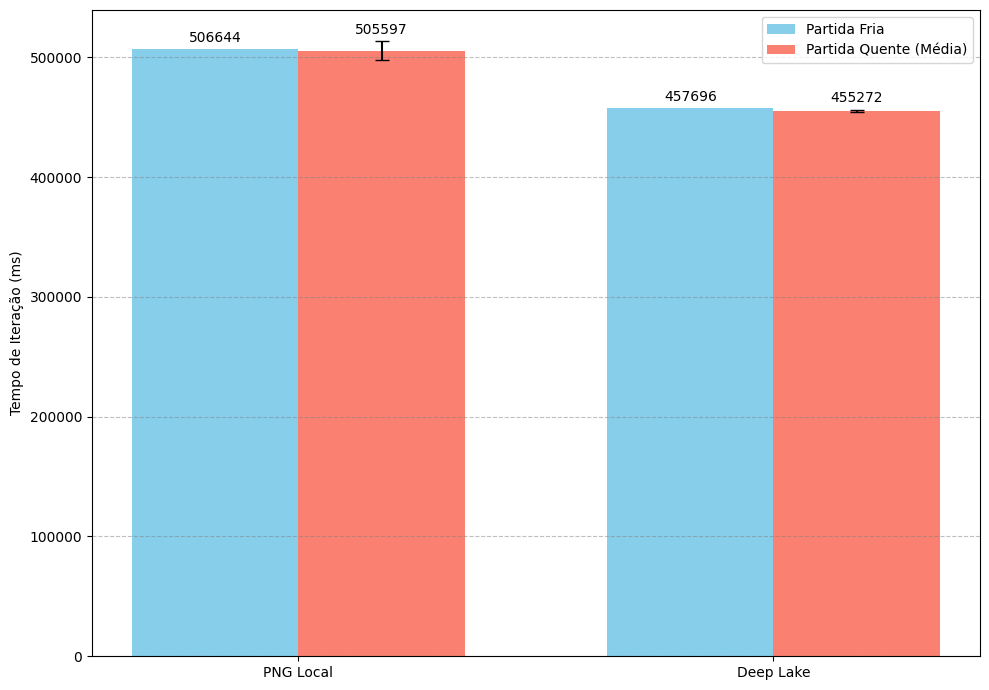

In [3]:
import matplotlib.pyplot as plt
import numpy as np

# 1. DADOS FORNECIDOS
# Os dados da sua análise foram organizados em um dicionário.
data = {
    'png_media_quente_ms': 505596.90,
    'png_std_quente_ms': 8170.16,
    'png_corrida_fria_ms': 506644.44,
    'dl_media_quente_ms': 455272.24,
    'dl_std_quente_ms': 1027.63,
    'dl_corrida_fria_ms': 457695.68
}

# 2. ORGANIZAÇÃO DOS DADOS PARA O GRÁFICO
# Separamos os dados em listas para facilitar a plotagem.
labels = ['PNG Local', 'Deep Lake']
cold_start_means = [data['png_corrida_fria_ms'], data['dl_corrida_fria_ms']]
hot_start_means = [data['png_media_quente_ms'], data['dl_media_quente_ms']]
hot_start_std = [data['png_std_quente_ms'], data['dl_std_quente_ms']]

# 3. CONFIGURAÇÃO DAS BARRAS
# Define a posição de cada grupo de barras no eixo X e a largura delas.
x = np.arange(len(labels))
width = 0.35  # Largura das barras

# 4. CRIAÇÃO DO GRÁFICO
# Inicia a figura e os eixos onde o gráfico será desenhado.
fig, ax = plt.subplots(figsize=(10, 7))

# Desenha as barras para o teste de "Partida Fria"
rects1 = ax.bar(x - width/2, cold_start_means, width, label='Partida Fria', color='skyblue')

# Desenha as barras para o teste de "Partida Quente"
# O parâmetro 'yerr' é usado para adicionar as barras de erro com base no desvio padrão.
# 'capsize' define o tamanho da pequena linha horizontal no topo da barra de erro.
rects2 = ax.bar(x + width/2, hot_start_means, width, label='Partida Quente (Média)', color='salmon', yerr=hot_start_std, capsize=5)

# 5. ADIÇÃO DE TÍTULOS, RÓTULOS E LEGENDA
ax.set_ylabel('Tempo de Iteração (ms)')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()

# 6. RÓTULOS DE DADOS
# Adiciona o valor numérico exato sobre cada barra para facilitar a leitura.
ax.bar_label(rects1, padding=3, fmt='%.0f')
ax.bar_label(rects2, padding=3, fmt='%.0f')

# 7. ESTÉTICA DO GRÁFICO
# Adiciona uma grade horizontal para ajudar na visualização dos valores.
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.5)

# Ajusta o layout para evitar que os elementos se sobreponham.
fig.tight_layout()

# 8. EXIBIÇÃO DO GRÁFICO
# Mostra o gráfico final. Para salvar em um arquivo, você usaria plt.savefig('nome_do_arquivo.png')
plt.show()

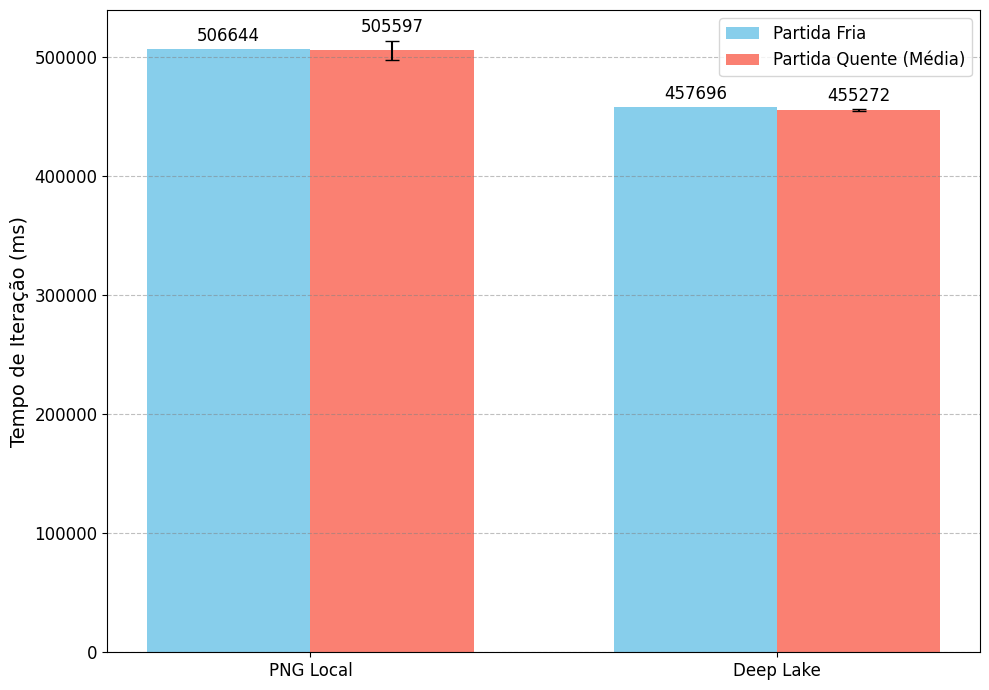

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. DADOS FORNECIDOS
# Os dados da sua análise foram organizados em um dicionário.
data = {
    'png_media_quente_ms': 505596.90,
    'png_std_quente_ms': 8170.16,
    'png_corrida_fria_ms': 506644.44,
    'dl_media_quente_ms': 455272.24,
    'dl_std_quente_ms': 1027.63,
    'dl_corrida_fria_ms': 457695.68
}

# 2. ORGANIZAÇÃO DOS DADOS PARA O GRÁFICO
# Separamos os dados em listas para facilitar a plotagem.
labels = ['PNG Local', 'Deep Lake']
cold_start_means = [data['png_corrida_fria_ms'], data['dl_corrida_fria_ms']]
hot_start_means = [data['png_media_quente_ms'], data['dl_media_quente_ms']]
hot_start_std = [data['png_std_quente_ms'], data['dl_std_quente_ms']]

# 3. CONFIGURAÇÃO DAS BARRAS
# Define a posição de cada grupo de barras no eixo X e a largura delas.
x = np.arange(len(labels))
width = 0.35  # Largura das barras

# 4. CRIAÇÃO DO GRÁFICO
# Inicia a figura e os eixos onde o gráfico será desenhado.
fig, ax = plt.subplots(figsize=(10, 7))

# Desenha as barras para o teste de "Partida Fria"
rects1 = ax.bar(x - width/2, cold_start_means, width, label='Partida Fria', color='skyblue')

# Desenha as barras para o teste de "Partida Quente"
# O parâmetro 'yerr' é usado para adicionar as barras de erro com base no desvio padrão.
# 'capsize' define o tamanho da pequena linha horizontal no topo da barra de erro.
rects2 = ax.bar(x + width/2, hot_start_means, width, label='Partida Quente (Média)', color='salmon', yerr=hot_start_std, capsize=5)

# 5. ADIÇÃO DE TÍTULOS, RÓTULOS E LEGENDA (com fontes maiores)
ax.set_ylabel('Tempo de Iteração (ms)', fontsize=16)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=14)
ax.legend(fontsize=14)

# Aumenta fonte dos ticks do eixo Y
ax.tick_params(axis='y', labelsize=14)

# 6. RÓTULOS DE DADOS
# Adiciona o valor numérico exato sobre cada barra para facilitar a leitura.
ax.bar_label(rects1, padding=3, fmt='%.0f', fontsize=14)
ax.bar_label(rects2, padding=3, fmt='%.0f', fontsize=14)

# 7. ESTÉTICA DO GRÁFICO
# Adiciona uma grade horizontal para ajudar na visualização dos valores.
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=.5)

# Ajusta o layout para evitar que os elementos se sobreponham.
fig.tight_layout()

# 8. EXIBIÇÃO DO GRÁFICO
# Mostra o gráfico final. Para salvar em um arquivo, você usaria plt.savefig('nome_do_arquivo.png')
plt.show()